## Import Libraries

In [26]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import joblib
import json

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Read dataset

In [29]:
df = pd.read_csv('dataClean.csv')
df.head()

,Date,Mode,Category,Subcategory,Note,Amount,Expense,Currency
0,2015-01-01 08:55:49,Cash,Food,Milk,tea,10.0,Expense,INR
1,2015-01-01 09:12:53,Cash,Transportation,auto,share auto - Place H to Place T base,20.0,Expense,INR
2,2015-01-01 09:29:14,Cash,Transportation,auto,share jeep - Place T to brc,60.0,Expense,INR
3,2015-01-01 09:48:16,Credit Card,Food,Milk,bendys chicken biryani,400.0,Expense,INR
4,2015-01-01 09:57:15,Cash,Transportation,auto,ropeway Place T to and fro,142.0,Expense,INR


### Dtype overview

In [32]:
df.shape

(2302, 8)

Contains 2302 rows and 9 columns

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         2302 non-null   object 
 1   Mode         2302 non-null   object 
 2   Category     2302 non-null   object 
 3   Subcategory  2302 non-null   object 
 4   Note         2302 non-null   object 
 5   Amount       2302 non-null   float64
 6   Expense      2302 non-null   object 
 7   Currency     2302 non-null   object 
dtypes: float64(1), object(7)
memory usage: 144.0+ KB


We need to convert `Date` dtype into datetime

## Preprocessing

### 1. Change `Date` datatype to timestamp

In [40]:
df['Date'] = pd.to_datetime(df['Date'])


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2302 entries, 0 to 2301
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         2302 non-null   datetime64[ns]
 1   Mode         2302 non-null   object        
 2   Category     2302 non-null   object        
 3   Subcategory  2302 non-null   object        
 4   Note         2302 non-null   object        
 5   Amount       2302 non-null   float64       
 6   Expense      2302 non-null   object        
 7   Currency     2302 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 144.0+ KB


### 2. Check missing value and duplicate

In [45]:
print('Missing value(s): ')  
print(df.isnull().sum())
print('=====' * 5)
print(f'Duplicate value(s): ', df.duplicated().sum())

Missing value(s): 
Date           0
Mode           0
Category       0
Subcategory    0
Note           0
Amount         0
Expense        0
Currency       0
dtype: int64
Duplicate value(s):  0


There are no missing values and duplication

### 3. Drop columns `Note` and `Currency`

In [49]:
# Drop irrelevant columns
df = df.drop(columns=['Note', 'Currency'])

### 4. Aggregate `Date` into `year`, `month`, `day`, and `dayofweek`

In [52]:
# Break the 'Date' column into year, month, day, day of week features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['dayofweek'] = df['Date'].dt.dayofweek  #(0 = Monday, 6 = Sunday)

# Drop 'Date' column after breaking it into year, month, day, day of week features
df = df.drop(columns=['Date'])

### 5. Convert INR into IDR

We just convert it based on nowdays currency rate

1 INR = 188.8 Rupiah (per 26 Nov 2024)

Then, we rounded to **200 Rupiah**

Source: **[Google Finance](https://www.google.com/finance/quote/INR-IDR?sa=X&ved=2ahUKEwj_gK6vrfmJAxUC3jgGHRSEHNAQmY0JegQIDRAu)**

In [56]:
df['Amount'].head()

0     10.0
1     20.0
2     60.0
3    400.0
4    142.0
Name: Amount, dtype: float64

In [58]:
# Konversi INR ke IDR
df['Amount'] = df['Amount'] * 200

In [60]:
df['Amount'].head()

0     2000.0
1     4000.0
2    12000.0
3    80000.0
4    28400.0
Name: Amount, dtype: float64

### 6. Change `Expense` column into numerical column

Because the value of the `Expense` just a string 'Expense'. Then it will be converted to numerical column

In [64]:
# Change all the values into 1
df['Expense'] = 1

### 7. Handle outliers in the 'Amount' column

In [67]:

# Calculate Q1 (First Quartile) and Q3 (Third Quartile)
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Determine lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from DataFrame
df = df[(df['Amount'] >= lower_bound) & (df['Amount'] <= upper_bound)]

# Display DataFrame information after removing outliers
print(f'Number of rows after removing outliers: {df.shape[0]}')
df.info()


Number of rows after removing outliers: 1966
<class 'pandas.core.frame.DataFrame'>
Index: 1966 entries, 0 to 2301
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Mode         1966 non-null   object 
 1   Category     1966 non-null   object 
 2   Subcategory  1966 non-null   object 
 3   Amount       1966 non-null   float64
 4   Expense      1966 non-null   int64  
 5   year         1966 non-null   int32  
 6   month        1966 non-null   int32  
 7   day          1966 non-null   int32  
 8   dayofweek    1966 non-null   int32  
dtypes: float64(1), int32(4), int64(1), object(3)
memory usage: 122.9+ KB


## Encoding Column

Encode `Mode`, `Category`, and `Subcategory`

In [71]:
# Encoding 'Mode'
encoder_mode = OneHotEncoder(sparse_output=False)
encoded_mode = encoder_mode.fit_transform(df[['Mode']])
mode_columns = encoder_mode.get_feature_names_out(['Mode'])

# Encoding 'Category'
encoder_category = OneHotEncoder(sparse_output=False)
encoded_category = encoder_category.fit_transform(df[['Category']])
category_columns = encoder_category.get_feature_names_out(['Category'])

# Encoding 'Subcategory'
encoder_subcategory = OneHotEncoder(sparse_output=False)
encoded_subcategory = encoder_subcategory.fit_transform(df[['Subcategory']])
subcategory_columns = encoder_subcategory.get_feature_names_out(['Subcategory'])

# Concatenate all encoded results into one df
encoded_df = pd.DataFrame(
    np.hstack([encoded_mode, encoded_category, encoded_subcategory]),
    columns=np.concatenate([mode_columns, category_columns, subcategory_columns])
)

# Concatenate the encoded results with original df
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Drop original encoded columns
df = df.drop(['Mode', 'Category', 'Subcategory'], axis=1)

# Show encoded results
df.head()


,Amount,Expense,year,month,day,dayofweek,Mode_CUB - online payment,Mode_Cash,Mode_Credit Card,Mode_Debit Card,...,Subcategory_gift,Subcategory_grooming,Subcategory_home decor,Subcategory_makeup,Subcategory_medicine,Subcategory_misc,Subcategory_ropeway,Subcategory_snacks,Subcategory_train,Subcategory_vegetables
0,2000.0,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4000.0,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,12000.0,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,80000.0,1,2015,1,1,3,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,28400.0,1,2015,1,1,3,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Normalization

### 1. Normalize `Amount`

In [75]:
# 1. Normalisasi data
scaler = MinMaxScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Only normalize `Amount` and not `Expense` column because `Expense`'s value already 1

### 2. Sorting data based on the time

In [79]:
# year, month, day
df = df.sort_values(by=['year', 'month', 'day']).reset_index(drop=True)

## Train-test-validation split

We use split ratio 70:15:15 for training, validation, and testing  

In [83]:
# 70% training, 15% validation, 15% test
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)

# Split into train, validation, and test
X = df.drop(columns=['Amount'])
y = df['Amount']

# Train set
X_train = X[:train_size]
y_train = y[:train_size]

# Validation set
X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

# Test set
X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

# Shape of split sets
print("Train Set Size:", X_train.shape)
print("Validation Set Size:", X_val.shape)
print("Test Set Size:", X_test.shape)

# Periode data
print("\nTrain Periode:", 
      f"from {X_train['year'].iloc[0]}-{X_train['month'].iloc[0]}-{X_train['day'].iloc[0]}",
      f"until {X_train['year'].iloc[-1]}-{X_train['month'].iloc[-1]}-{X_train['day'].iloc[-1]}")
print("Validation Periode:", 
      f"from {X_val['year'].iloc[0]}-{X_val['month'].iloc[0]}-{X_val['day'].iloc[0]}",
      f"until {X_val['year'].iloc[-1]}-{X_val['month'].iloc[-1]}-{X_val['day'].iloc[-1]}")
print("Test Periode:", 
      f"from {X_test['year'].iloc[0]}-{X_test['month'].iloc[0]}-{X_test['day'].iloc[0]}",
      f"until {X_test['year'].iloc[-1]}-{X_test['month'].iloc[-1]}-{X_test['day'].iloc[-1]}")

Train Set Size: (1376, 121)
Validation Set Size: (294, 121)
Test Set Size: (296, 121)

Train Periode: from 2015-1-1 until 2018-3-1
Validation Periode: from 2018-3-1 until 2018-8-21
Test Periode: from 2018-8-22 until 2022-3-2


## Sequences

### 1. Sequences Function

Make sequences for time series forecasting with parameter
- X: features
- y: target
- window_size: the day before prediction
- horizon: the next day for prediction

In [88]:
def create_sequences(X, y, window_size=10, horizon=20):

    # Array to keep sequences
    X_seq, y_seq = [], []
    
    for i in range(len(X) - window_size - horizon + 1):
        # Sequence input
        X_seq.append(X[i:(i + window_size)].values)
        # Target output (horizon for next day)
        y_seq.append(y[i + window_size:i + window_size + horizon].values)
    
    return np.array(X_seq), np.array(y_seq)

### 2. Define Parameters

In this model, we will use the first 10 days for the training process and for the next 20 days used as a prediction output.

In [92]:
WINDOW_SIZE = 10  # First 10 days
HORIZON = 20      # Predict next 20 days

### 3. Create Sequences

In [95]:
# Sequences for training set
X_train_seq, y_train_seq = create_sequences(X_train, y_train, 
                                          window_size=WINDOW_SIZE, 
                                          horizon=HORIZON)

# Sequences for validation set
X_val_seq, y_val_seq = create_sequences(X_val, y_val,
                                      window_size=WINDOW_SIZE,
                                      horizon=HORIZON)

# Sequences for test set
X_test_seq, y_test_seq = create_sequences(X_test, y_test,
                                        window_size=WINDOW_SIZE,
                                        horizon=HORIZON)

# Print shape
print("Shape of X train sequences:", X_train_seq.shape)
print("Shape of y train sequences:", y_train_seq.shape)
print("Shape of X validation sequences:", X_val_seq.shape)
print("Shape of y validation sequences:", y_val_seq.shape)
print("Shape of X test sequences:", X_test_seq.shape)
print("Shape of y test sequences:", y_test_seq.shape)

Shape of X train sequences: (1347, 10, 121)
Shape of y train sequences: (1347, 20)
Shape of X validation sequences: (265, 10, 121)
Shape of y validation sequences: (265, 20)
Shape of X test sequences: (267, 10, 121)
Shape of y test sequences: (267, 20)


## Modeling

### 1. Model Function 

In [99]:
def create_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(256, activation='relu', 
                             return_sequences=True, 
                             input_shape=input_shape),      # LSTM layer
        tf.keras.layers.Dropout(0.3),                       # Dropout layer for regularization (avoid overfitting)
        
        tf.keras.layers.LSTM(128, activation='relu', 
                             return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(128, activation='relu'),      # Dense layer
        tf.keras.layers.Dense(64, activation='relu'),   
        tf.keras.layers.Dense(HORIZON)                      # Output layer for predict HORIZON
    ])
    
    return model

# Model Initialization
input_shape = (WINDOW_SIZE, X_train.shape[1])               # (sequence_length, features)
model = create_model(input_shape)

# Compile model
model.compile(optimizer='adam',
             loss=tf.losses.MeanSquaredError(),
             metrics=['mae'])

# Summary
model.summary()

c:\Dirzys_Code\Anaconda\envs\InsightkuProject\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 10, 256)             │         387,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 10, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 10, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 10, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           1,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 651,476 (2.49 MB)

 Trainable params: 651,476 (2.49 MB)

 Non-trainable params: 0 (0.00 B)

In [101]:
# def create_hybrid_model(input_shape):
#     model = tf.keras.Sequential([
#         # Leaky ReLU
#         tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation=tf.keras.layers.LeakyReLU(alpha=0.1), 
#                                input_shape=input_shape),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.Dropout(0.3),
        
#         # ELU
#         # biderectional LSTM
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, activation='elu', return_sequences=True)),
#         tf.keras.layers.Dropout(0.3),
        
#         # Parametric ReLU
#         tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation=tf.keras.layers.PReLU(),
#                                input_shape=input_shape),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.Dropout(0.3),
        
#         # ELU LSTM
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='elu')),
#         tf.keras.layers.Dropout(0.2),

#         # Dense layers with ReLU
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dropout(0.4),
        
#         # Dense layers with ReLU
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dropout(0.2),
        
#         tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
#         tf.keras.layers.Dropout(0.2),
        
#         # Output layer
#         tf.keras.layers.Dense(HORIZON)
#     ])
    
#     return model


# # Model Initialization
# input_shape = (WINDOW_SIZE, X_train.shape[1])  # (sequence_length, features)
# model = create_hybrid_model(input_shape)

# # Compile model
# model.compile(optimizer='adam',
#              loss=tf.losses.MeanSquaredError(),
#              metrics=['mae'])

# # Summary
# model.summary()

### 2. Callbacks

In [104]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=0.0001, 
    restore_best_weights=True
)

In [106]:
# # Tambahkan learning rate scheduler
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=10,
#     min_lr=0.00001
# )

### 3. Traning model

100 epochs and 32 batch_size

In [110]:
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=200,
    batch_size=16,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - loss: 1385.6538 - mae: 22.0266 - val_loss: 1.5529 - val_mae: 1.0310
Epoch 2/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 19.9734 - mae: 2.7635 - val_loss: 0.0738 - val_mae: 0.1698
Epoch 3/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.0485 - mae: 1.2285 - val_loss: 0.0731 - val_mae: 0.1680
Epoch 4/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 2.3041 - mae: 0.6724 - val_loss: 0.0722 - val_mae: 0.1657
Epoch 5/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.4054 - mae: 0.4659 - val_loss: 0.0713 - val_mae: 0.1633
Epoch 6/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.8772 - mae: 0.3481 - val_loss: 0.0703 - val_mae: 0.1607
Epoch 7/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.3846 - mae: 0.2697 - val_loss: 0.0691 - val_mae: 0.1579
Epoch 8/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.5765 - mae: 0.2822 - val_loss: 0.0679 - val_mae: 0.1551
Epoch 9/200
85/85 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

### 4. Evaluate on test set

In [112]:
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')


Test Loss: 0.0428
Test MAE: 0.1460


## Prediction

In [116]:
train_predictions = model.predict(X_train_seq)  # Predictions for training set
val_predictions = model.predict(X_val_seq)      # Predictions for validation set
test_predictions = model.predict(X_test_seq)    # Predictions for test set

43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


### 2. Inverse Transform

Inverse transform is the process of returning data that has been normalized to its original scale.

In [120]:
# Inverse transform untuk mendapatkan nilai asli (sebelum scaling)
def inverse_transform_predictions(predictions):
   # Reshape predictions ke 2D array
   predictions_reshaped = predictions.reshape(-1, 1)
   # Inverse transform
   return scaler.inverse_transform(predictions_reshaped).reshape(predictions.shape)

In [122]:
# Inverse transform target dan predictions
# y_train_orig = scaler.inverse_transform(y_train_seq.reshape(-1, 1)).reshape(y_train_seq.shape)
# y_val_orig = scaler.inverse_transform(y_val_seq.reshape(-1, 1)).reshape(y_val_seq.shape)
y_test_orig = scaler.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(y_test_seq.shape)

# train_pred_orig = inverse_transform_predictions(train_predictions)
# val_pred_orig = inverse_transform_predictions(val_predictions)
test_pred_orig = inverse_transform_predictions(test_predictions)

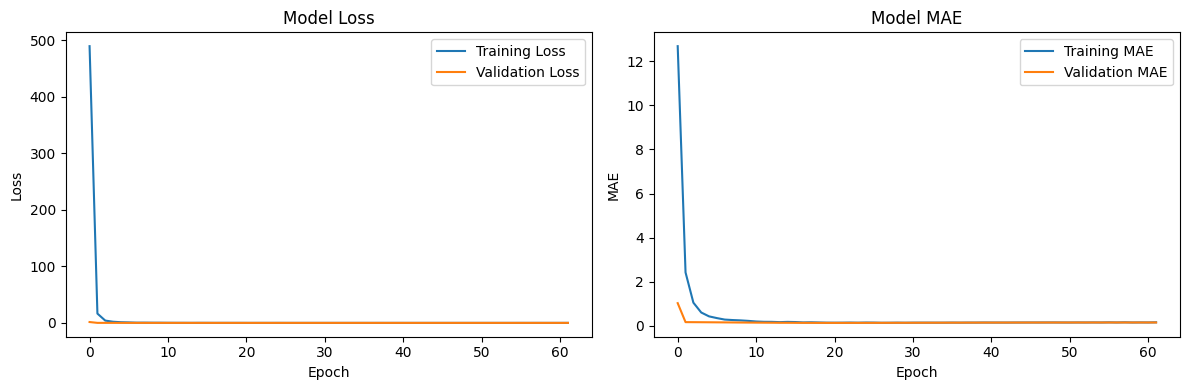

In [124]:
# Visualisasi hasil training
def plot_training_history(history):
   plt.figure(figsize=(12, 4))
   
   # Plot training & validation loss
   plt.subplot(1, 2, 1)
   plt.plot(history.history['loss'], label='Training Loss')
   plt.plot(history.history['val_loss'], label='Validation Loss')
   plt.title('Model Loss')
   plt.xlabel('Epoch')
   plt.ylabel('Loss')
   plt.legend()
   
   # Plot training & validation MAE
   plt.subplot(1, 2, 2)
   plt.plot(history.history['mae'], label='Training MAE')
   plt.plot(history.history['val_mae'], label='Validation MAE')
   plt.title('Model MAE')
   plt.xlabel('Epoch')
   plt.ylabel('MAE')
   plt.legend()
   
   plt.tight_layout()
   plt.show()

# Plot hasil training
plot_training_history(history)

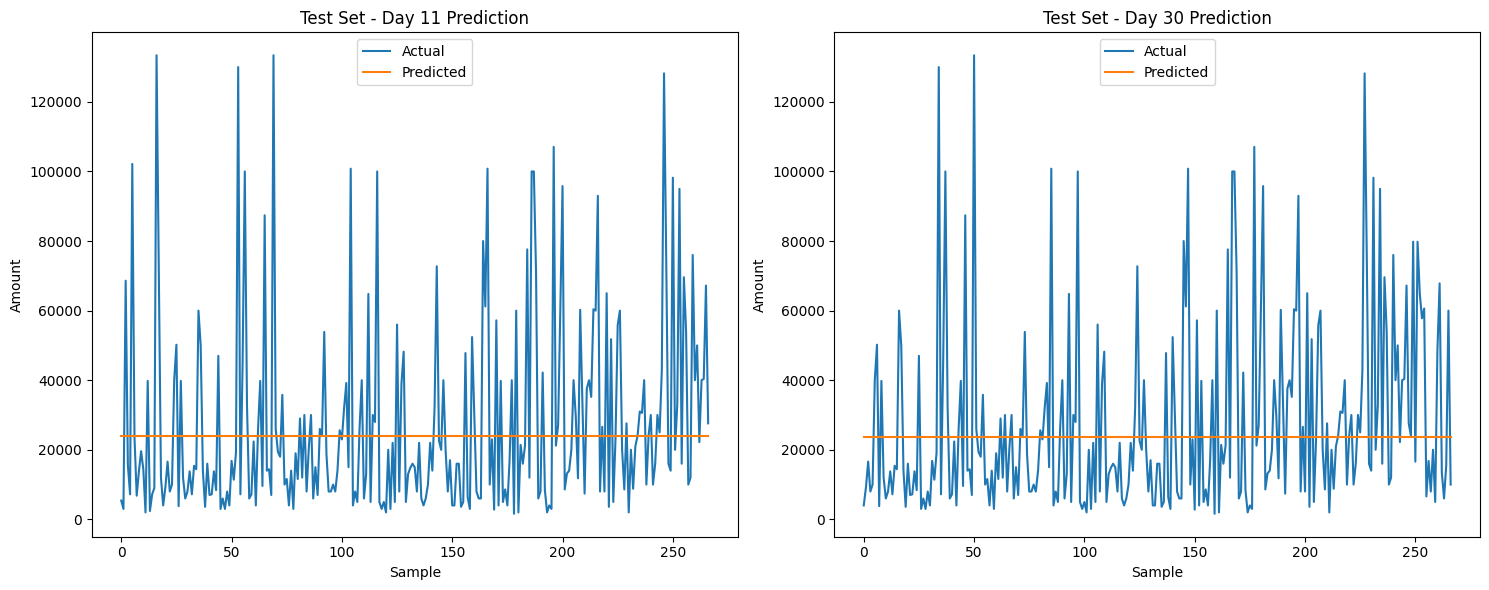

In [126]:
# Visualisasi prediksi vs aktual
def plot_predictions(y_true, y_pred, title):
   plt.figure(figsize=(15, 6))
   
   # Plot untuk hari pertama yang diprediksi
   plt.subplot(1, 2, 1)
   plt.plot(y_true[:, 0], label='Actual')
   plt.plot(y_pred[:, 0], label='Predicted')
   plt.title(f'{title} - Day 11 Prediction')
   plt.xlabel('Sample')
   plt.ylabel('Amount')
   plt.legend()
   
   # Plot untuk hari terakhir yang diprediksi
   plt.subplot(1, 2, 2)
   plt.plot(y_true[:, -1], label='Actual')
   plt.plot(y_pred[:, -1], label='Predicted')
   # plt.title(f'{title} - Day {HORIZON} Prediction')
   plt.title(f'{title} - Day 30 Prediction')

   plt.xlabel('Sample')
   plt.ylabel('Amount')
   plt.legend()
   
   
   plt.tight_layout()
   plt.show()

# Plot prediksi untuk setiap set
# plot_predictions(y_train_orig, train_pred_orig, 'Training Set')
# plot_predictions(y_val_orig, val_pred_orig, 'Validation Set')
plot_predictions(y_test_orig, test_pred_orig, 'Test Set')

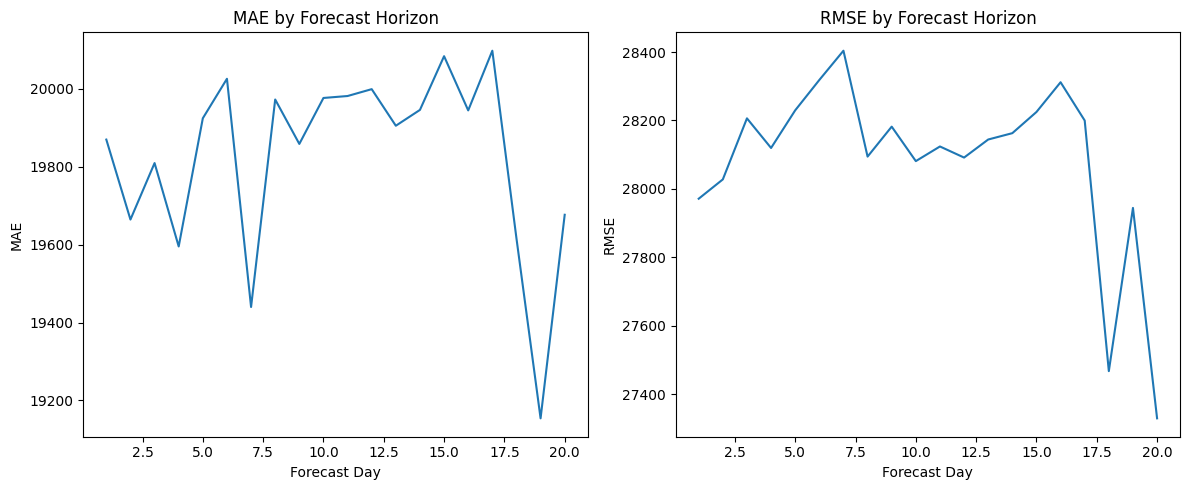


Metrik Evaluasi Test Set:
Average MAE across all horizons: 19826.63
Average RMSE across all horizons: 28081.82

MAE for Day 1 prediction: 19869.20
MAE for Day 20 prediction: 19676.38


In [128]:
# Hitung metrik evaluasi untuk setiap horizon prediksi
def calculate_metrics_by_horizon(y_true, y_pred):
   mae_by_horizon = []
   rmse_by_horizon = []
   
   for i in range(HORIZON):
       mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
       rmse = np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i]))
       mae_by_horizon.append(mae)
       rmse_by_horizon.append(rmse)
   
   return mae_by_horizon, rmse_by_horizon

# Hitung metrik untuk test set
test_mae_by_horizon, test_rmse_by_horizon = calculate_metrics_by_horizon(y_test_orig, test_pred_orig)

# Visualisasi metrik berdasarkan horizon
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, HORIZON + 1), test_mae_by_horizon)
plt.title('MAE by Forecast Horizon')
plt.xlabel('Forecast Day')
plt.ylabel('MAE')

plt.subplot(1, 2, 2)
plt.plot(range(1, HORIZON + 1), test_rmse_by_horizon)
plt.title('RMSE by Forecast Horizon')
plt.xlabel('Forecast Day')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()

# Print rangkuman metrik
print("\nMetrik Evaluasi Test Set:")
print(f"Average MAE across all horizons: {np.mean(test_mae_by_horizon):.2f}")
print(f"Average RMSE across all horizons: {np.mean(test_rmse_by_horizon):.2f}")
print(f"\nMAE for Day 1 prediction: {test_mae_by_horizon[0]:.2f}")
print(f"MAE for Day {HORIZON} prediction: {test_mae_by_horizon[-1]:.2f}")

In [130]:
# 3. Simpan model dalam beberapa format
# Simpan model lengkap (arsitektur + bobot)
model.save('expense_forecast_model.h5')

# Simpan arsitektur model dalam format JSON
model_json = model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

# Simpan bobot model
model.save_weights('model.weights.h5')

In [132]:
# 4. Simpan parameter penting untuk preprocessing
import json

model_params = {
    'window_size': WINDOW_SIZE,
    'horizon': HORIZON,
    'input_shape': input_shape[1],
    'feature_columns': list(X_train.columns)
}

with open('model_params.json', 'w') as f:
    json.dump(model_params, f)

print("Model dan parameter telah disimpan!")

Model dan parameter telah disimpan!


In [134]:
# 5. Contoh cara memuat model untuk prediksi di masa depan
def load_forecasting_model():
    # Muat model
    loaded_model = tf.keras.models.load_model('expense_forecast_model.h5')
    
    # Muat parameter
    with open('model_params.json', 'r') as f:
        params = json.load(f)
    
    # Muat scaler
    loaded_scaler = joblib.load('scaler.pkl')
    
    return loaded_model, params, loaded_scaler

In [136]:
# 6. Fungsi untuk membuat prediksi baru
def make_prediction(model, scaler, new_data, params):
    """
    new_data: DataFrame dengan format yang sama seperti data training
    """
    # Preprocessing data baru
    sequences = create_sequences(new_data, 
                               window_size=params['window_size'],
                               horizon=params['horizon'])
    
    # Buat prediksi
    predictions = model.predict(sequences)
    
    # Inverse transform prediksi
    predictions_orig = scaler.inverse_transform(predictions.reshape(-1, 1))
    
    return predictions_orig.reshape(predictions.shape)

print("\nCara menggunakan model yang telah disimpan:")
print("""
# Muat model
loaded_model, params, loaded_scaler = load_forecasting_model()

# Siapkan data baru (harus memiliki kolom yang sama dengan data training)
new_data = prepare_new_data()  # Fungsi untuk memproses data baru

# Buat prediksi
predictions = make_prediction(loaded_model, loaded_scaler, new_data, params)
""")


Cara menggunakan model yang telah disimpan:

# Muat model
loaded_model, params, loaded_scaler = load_forecasting_model()

# Siapkan data baru (harus memiliki kolom yang sama dengan data training)
new_data = prepare_new_data()  # Fungsi untuk memproses data baru

# Buat prediksi
predictions = make_prediction(loaded_model, loaded_scaler, new_data, params)



# Predict

In [139]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [141]:
# 1. Fungsi untuk mempersiapkan data baru
def prepare_new_data(input_data):
    """
    input_data: DataFrame dengan format yang sama seperti data training asli
    """
    # Konversi tanggal
    input_data['Date'] = pd.to_datetime(input_data['Date'])
    
    # Buat fitur tanggal
    input_data['year'] = input_data['Date'].dt.year
    input_data['month'] = input_data['Date'].dt.month
    input_data['day'] = input_data['Date'].dt.day
    input_data['dayofweek'] = input_data['Date'].dt.dayofweek
    
    # Hapus kolom yang tidak diperlukan
    input_data = input_data.drop(columns=['Note', 'Currency', 'Date'])
    
    # One-hot encoding untuk kolom kategorikal
    # Gunakan encoder yang sama dengan data training
    encoded_mode = encoder_mode.transform(input_data[['Mode']])
    encoded_category = encoder_category.transform(input_data[['Category']])
    encoded_subcategory = encoder_subcategory.transform(input_data[['Subcategory']])
    
    # Gabungkan hasil encoding
    encoded_df = pd.DataFrame(
        np.hstack([encoded_mode, encoded_category, encoded_subcategory]),
        columns=np.concatenate([mode_columns, category_columns, subcategory_columns])
    )
    
    # Gabungkan dengan data asli
    processed_data = pd.concat([
        input_data.drop(['Mode', 'Category', 'Subcategory'], axis=1),
        encoded_df
    ], axis=1)
    
    return processed_data

In [143]:
# 2. Fungsi untuk membuat prediksi
def predict_future_expenses(input_data, days_to_predict=20):
    """
    input_data: DataFrame dengan data 10 hari terakhir
    days_to_predict: Jumlah hari yang akan diprediksi
    """
    # Muat model dan komponen yang diperlukan
    loaded_model, params, loaded_scaler = load_forecasting_model()
    
    # Persiapkan data
    processed_data = prepare_new_data(input_data)
    
    # Normalisasi Amount
    processed_data['Amount'] = loaded_scaler.transform(processed_data[['Amount']])
    
    # Buat sequence untuk prediksi
    X_pred = processed_data.drop(columns=['Amount'])
    X_pred_seq = np.array([X_pred.values[-WINDOW_SIZE:]])
    
    # Buat prediksi
    predictions = loaded_model.predict(X_pred_seq)
    
    # Inverse transform prediksi
    predictions_orig = loaded_scaler.inverse_transform(predictions.reshape(-1, 1))
    
    # Buat DataFrame hasil prediksi
    last_date = input_data['Date'].iloc[-1]
    future_dates = [last_date + timedelta(days=i+1) for i in range(days_to_predict)]
    
    predictions_df = pd.DataFrame({
        'Date': future_dates,
        'Predicted_Amount': predictions_orig.flatten()
    })
    
    return predictions_df

In [145]:
# 3. Contoh penggunaan
# Asumsikan Anda memiliki data 10 hari pertama
data_10_hari = pd.DataFrame({
    'Date': pd.date_range(start='2024-01-01', periods=10),
    'Mode': ['Cash'] * 10,  # Sesuaikan dengan data Anda
    'Category': ['Food'] * 10,  # Sesuaikan dengan data Anda
    'Subcategory': ['Lunch'] * 10,  # Sesuaikan dengan data Anda
    'Note': [''] * 10,
    'Amount': np.random.randint(20000, 2000000, 10),  # Contoh jumlah
    'Expense': [1] * 10,
    'Currency': ['IDR'] * 10
})

In [147]:
# Tampilkan hasil data_10_hari
print("Data 10 hari pertama:")
print(data_10_hari['Amount'])

Data 10 hari pertama:
0    1217800
1    1776963
2     215554
3    1480294
4    1729642
5     183950
6     846173
7     923295
8    1733972
9    1106945
Name: Amount, dtype: int32


In [149]:
# Lakukan prediksi
predictions = predict_future_expenses(data_10_hari, days_to_predict=20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step


In [151]:
# Tambah kode apabila nilai prediksi negatif, maka akan diubah menjadi 0
predictions['Predicted_Amount'] = predictions['Predicted_Amount'].apply(lambda x: max(0, x))

In [153]:
# Tampilkan hasil
print("\nPrediksi pengeluaran untuk 20 hari ke depan:")
# print ubah ke IDR dan integer
# predictions['Predicted_Amount'] = predictions['Predicted_Amount'].astype(int)
print(predictions.to_string(index=False))


Prediksi pengeluaran untuk 20 hari ke depan:
      Date  Predicted_Amount
2024-01-11      23904.359375
2024-01-12      23318.507812
2024-01-13      23361.056641
2024-01-14      23055.621094
2024-01-15      23704.634766
2024-01-16      23743.841797
2024-01-17      21470.853516
2024-01-18      23629.146484
2024-01-19      23091.935547
2024-01-20      23696.814453
2024-01-21      23516.683594
2024-01-22      23697.429688
2024-01-23      23310.445312
2024-01-24      23346.404297
2024-01-25      23587.208984
2024-01-26      23024.880859
2024-01-27      23713.558594
2024-01-28      23241.238281
2024-01-29      20628.515625
2024-01-30      23700.000000


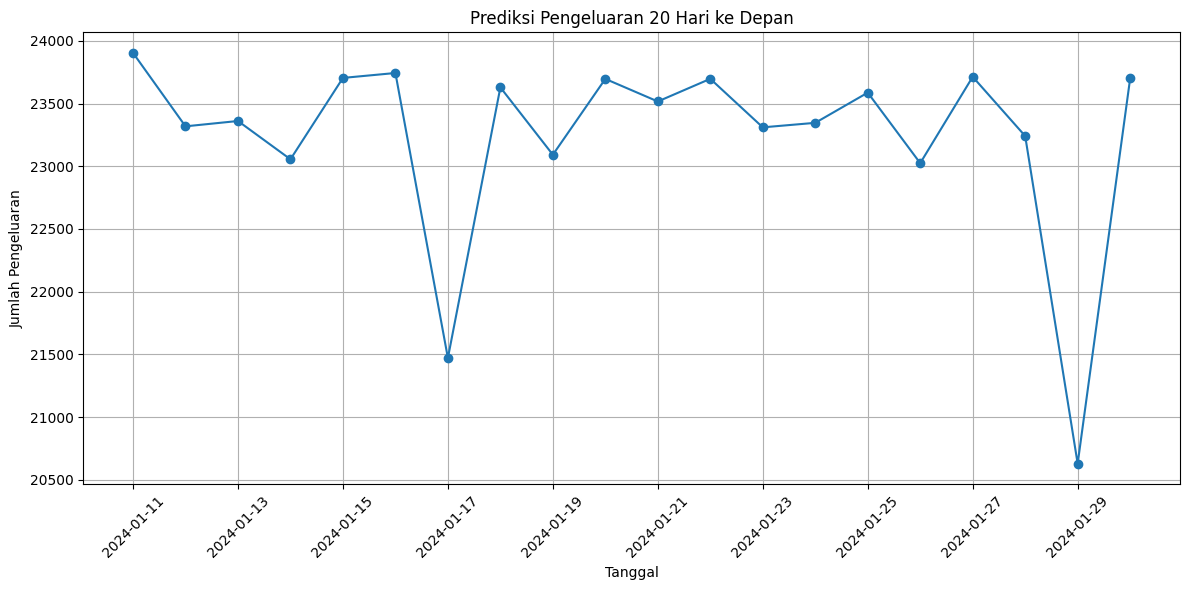


Statistik Prediksi:
Rata-rata pengeluaran harian: 23237.16
Pengeluaran minimum: 20628.52
Pengeluaran maksimum: 23904.36
Total pengeluaran 20 hari: 464743.14


In [155]:
# Visualisasi hasil
plt.figure(figsize=(12, 6))
plt.plot(predictions['Date'], predictions['Predicted_Amount'], marker='o')
plt.title('Prediksi Pengeluaran 20 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Pengeluaran')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Statistik prediksi
print("\nStatistik Prediksi:")
print(f"Rata-rata pengeluaran harian: {predictions['Predicted_Amount'].mean():.2f}")
print(f"Pengeluaran minimum: {predictions['Predicted_Amount'].min():.2f}")
print(f"Pengeluaran maksimum: {predictions['Predicted_Amount'].max():.2f}")
print(f"Total pengeluaran 20 hari: {predictions['Predicted_Amount'].sum():.2f}")

# Compare Diff Arch

### Ini gausa dipake, cuman code tambahan buat ganti model sama bandingin

In [46]:
# Encoding kolom 'Mode'
encoder_mode = OneHotEncoder(sparse_output=False)
encoded_mode = encoder_mode.fit_transform(df[['Mode']])
mode_columns = encoder_mode.get_feature_names_out(['Mode'])

# Encoding kolom 'Category'
encoder_category = OneHotEncoder(sparse_output=False)
encoded_category = encoder_category.fit_transform(df[['Category']])
category_columns = encoder_category.get_feature_names_out(['Category'])

# Encoding kolom 'Subcategory'
encoder_subcategory = OneHotEncoder(sparse_output=False)
encoded_subcategory = encoder_subcategory.fit_transform(df[['Subcategory']])
subcategory_columns = encoder_subcategory.get_feature_names_out(['Subcategory'])

# Gabungkan semua hasil encoding ke dalam satu dataframe
encoded_df = pd.DataFrame(
    np.hstack([encoded_mode, encoded_category, encoded_subcategory]),
    columns=np.concatenate([mode_columns, category_columns, subcategory_columns])
)

# Gabungkan hasil encoding dengan dataframe asli
df = pd.concat([df.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Drop kolom asli yang telah di-encode
df = df.drop(['Mode', 'Category', 'Subcategory'], axis=1)


# Tampilkan hasil encoding
df.head()


KeyError: "None of [Index(['Mode'], dtype='object')] are in the [columns]"

In [ ]:
# 1. Definisikan model dengan arsitektur yang lebih kompleks
def create_model(input_shape):
    model = tf.keras.Sequential([
        # Menambah kompleksitas model
        tf.keras.layers.LSTM(128, activation='relu', 
                           return_sequences=True, 
                           input_shape=input_shape),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(64, activation='relu',
                           return_sequences=True),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.LSTM(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(HORIZON)
    ])
    return model

# 2. Inisialisasi model baru
input_shape = (WINDOW_SIZE, X_train.shape[1])
model = create_model(input_shape)

# 3. Compile model dengan learning rate yang diubah
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 10, 128)        │       133,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 10, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 20)             │           660 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 200,308 (782.45 KB)

 Trainable params: 200,308 (782.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4. Definisikan callbacks
# Early stopping dengan patience lebih besar
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    min_delta=0.0001
)

In [ ]:
# Learning rate scheduler
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001,
    verbose=1
)

In [ ]:
# 5. Training model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_seq, y_val_seq),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - loss: 1106.2311 - mae: 19.9857 - val_loss: 3.0128 - val_mae: 1.4356 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - loss: 25.0877 - mae: 3.2337 - val_loss: 1.0156 - val_mae: 0.7323 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 13.2648 - mae: 2.0301 - val_loss: 0.0017 - val_mae: 0.0269 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 6.4553 - mae: 1.2725 - val_loss: 0.0147 - val_mae: 0.0804 - learning_rate: 0.0010
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.2510 - mae: 0.8165 - val_loss: 0.0019 - val_mae: 0.0307 - learning_rate: 0.0010
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 1.7496 - mae: 0.5617 - val_loss: 0.0019 - val_mae: 0.0314 - learning_rate: 0.0010
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.2989 - mae: 0.4479 - val_loss: 0.0020 - val_mae: 0.0321 - learning_rate: 0.00

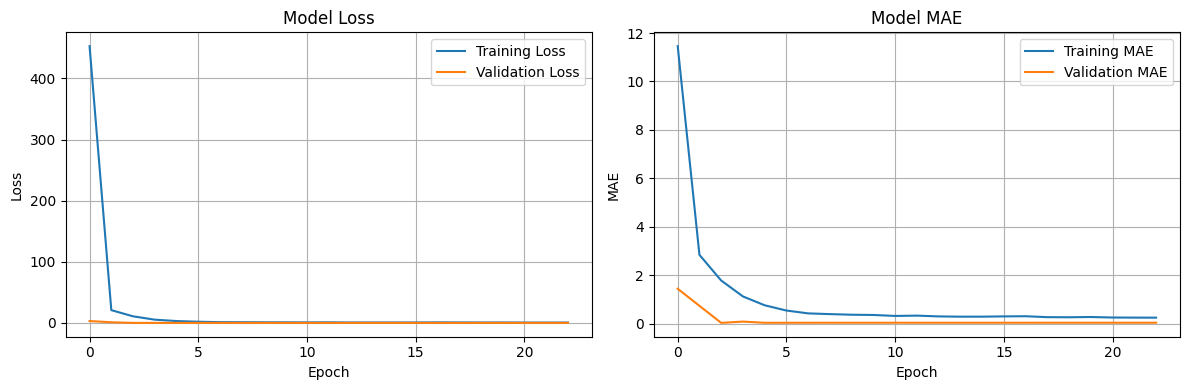

In [ ]:
# 6. Visualisasi hasil training yang baru
plt.figure(figsize=(12, 4))

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training & validation MAE
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 7. Print ringkasan training
print("\nRingkasan Training:")
print(f"Total epochs: {len(history.history['loss'])}")
print(f"Best validation loss: {min(history.history['val_loss']):.4f}")
print(f"Best validation MAE: {min(history.history['val_mae']):.4f}")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")



Ringkasan Training:
Total epochs: 23
Best validation loss: 0.0017
Best validation MAE: 0.0269
Final training loss: 0.5852
Final validation loss: 0.0021


In [ ]:

# 8. Evaluasi pada test set
test_loss, test_mae = model.evaluate(X_test_seq, y_test_seq, verbose=0)
print(f'\nTest Loss: {test_loss:.4f}')
print(f'Test MAE: {test_mae:.4f}')


Test Loss: 0.0019
Test MAE: 0.0268


In [ ]:
# 9. Bandingkan performa dengan model sebelumnya
test_predictions = model.predict(X_test_seq)
test_pred_orig = inverse_transform_predictions(test_predictions)
y_test_orig = scaler.inverse_transform(y_test_seq.reshape(-1, 1)).reshape(y_test_seq.shape)

# Hitung metrik untuk test set
test_mae_by_horizon, test_rmse_by_horizon = calculate_metrics_by_horizon(y_test_orig, test_pred_orig)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


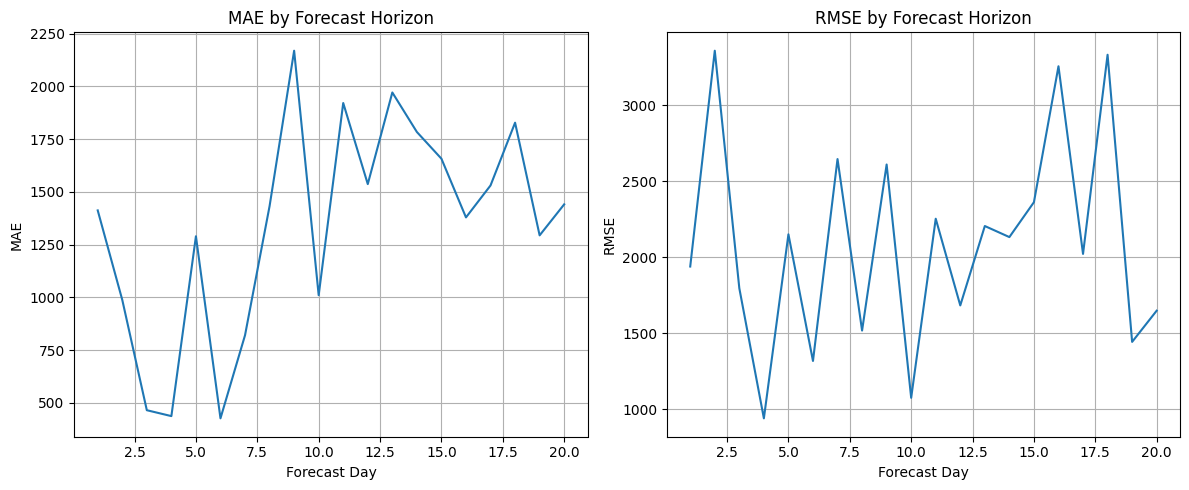

In [ ]:
# Visualisasi metrik berdasarkan horizon
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, HORIZON + 1), test_mae_by_horizon)
plt.title('MAE by Forecast Horizon')
plt.xlabel('Forecast Day')
plt.ylabel('MAE')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, HORIZON + 1), test_rmse_by_horizon)
plt.title('RMSE by Forecast Horizon')
plt.xlabel('Forecast Day')
plt.ylabel('RMSE')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Print metrik evaluasi
print("\nMetrik Evaluasi Test Set:")
print(f"Average MAE across all horizons: {np.mean(test_mae_by_horizon):.2f}")
print(f"Average RMSE across all horizons: {np.mean(test_rmse_by_horizon):.2f}")
print(f"MAE for Day 1 prediction: {test_mae_by_horizon[0]:.2f}")
print(f"MAE for Day {HORIZON} prediction: {test_mae_by_horizon[-1]:.2f}")


Metrik Evaluasi Test Set:
Average MAE across all horizons: 1339.60
Average RMSE across all horizons: 2085.09
MAE for Day 1 prediction: 1412.09
MAE for Day 20 prediction: 1440.70
